# Inhaltsverzeichnis

| Abschnitt | Unterabschnitt |
|-----------|----------------|
| **[Daily Data TSLM Model](#daily-data-tslm-model)** | |
[Residuenanalyse](#residuenanalyse)||
 [Stationaritätsstatistische Tests](#stationaritaetsstatistische-tests)||
  [Cross validation](#cross-validation) ||


# Daily Data TSLM Model

                            OLS Regression Results                            
Dep. Variable:        Log_Fire_Counts   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                 8.349e+04
Date:                Sun, 12 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:57:30   Log-Likelihood:            -3.4345e+05
No. Observations:              675636   AIC:                         6.869e+05
Df Residuals:                  675628   BIC:                         6.870e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.3480    

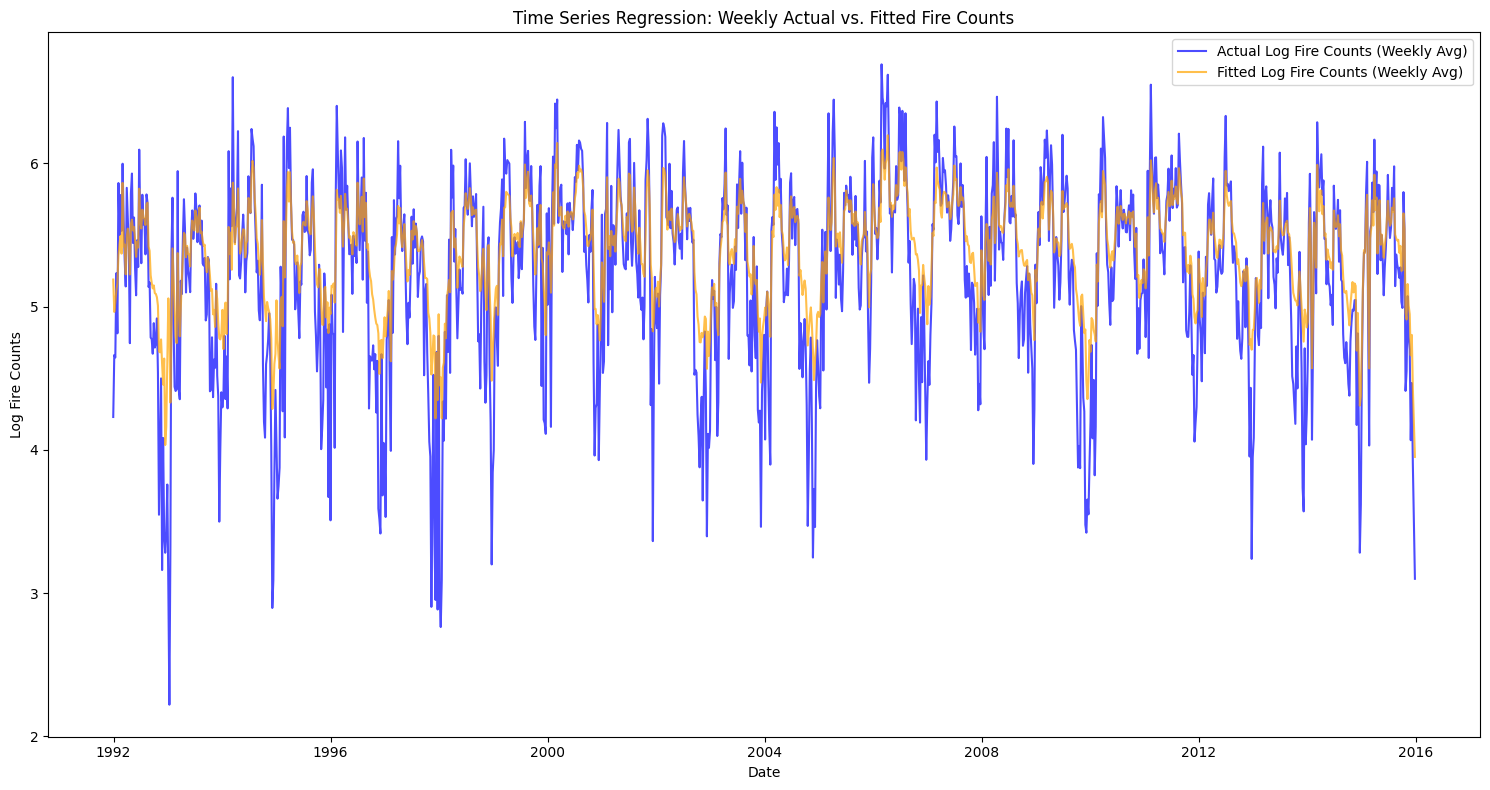

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import joblib

# Load the dataset
data_path = 'Data_Waldbrand_Zeitreihen/daily_data_merged/merged_with_daily_fire_counts.csv'
data = pd.read_csv(data_path)

# Ensure dates are in datetime format
data['DISCOVERY_DATE'] = pd.to_datetime(data['DISCOVERY_DATE'])
data.set_index('DISCOVERY_DATE', inplace=True)

# Log-transform the fire counts
data['Log_Fire_Counts'] = np.log1p(data['Daily Fire Counts'])

# Create time-step feature
data['Time_Trend'] = np.arange(len(data))

# Create lag features
data['Lag_1'] = data['Log_Fire_Counts'].shift(1)
data['Lag_2'] = data['Log_Fire_Counts'].shift(2)

# Drop rows with missing values due to lagging
data.dropna(inplace=True)

# Define the predictors and target
X = data[['Time_Trend', 'Lag_1', 'Lag_2', 'Precipitation', 'Inferred_Wind_Speed', 'MaxTemperature', 'MinTemperature']]
y = data['Log_Fire_Counts']

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Fit the TSLM (time series linear model) using OLS
model = sm.OLS(y, X).fit()

# Display and save the model summary
model_summary = model.summary()
print(model_summary)

# Save the model summary as a PNG file
summary_output_dir = 'Abbildungen'
os.makedirs(summary_output_dir, exist_ok=True)
summary_file_path = os.path.join(summary_output_dir, 'TSLM_model_summary.png')
fig = plt.figure(figsize=(12, 6))
plt.text(0.01, 0.05, str(model_summary), {'fontsize': 10}, fontproperties='monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(summary_file_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()
print(f"Model summary saved at: {summary_file_path}")

# Save the model
model_file_path = os.path.join(summary_output_dir, 'TSLM_model.pkl')
joblib.dump(model, model_file_path)
print(f"Model saved at: {model_file_path}")

# Add the fitted values to the dataset
data['Fitted_Log_Fire_Counts'] = model.predict(X)

# Save residuals
residuals_output_dir = 'Data_Waldbrand_Zeitreihen/daily_data_merged'
os.makedirs(residuals_output_dir, exist_ok=True)
residuals_file_path = os.path.join(residuals_output_dir, 'TSLM_model_residuals.csv')
residuals = y - data['Fitted_Log_Fire_Counts']
residuals_df = pd.DataFrame({'Residuals': residuals})
residuals_df.to_csv(residuals_file_path, index=True)
print(f"Residuals saved at: {residuals_file_path}")

# Aggregate data to weekly means for clarity
data['Week'] = data.index.to_period('W').start_time
weekly_data = data.groupby('Week').agg({
    'Log_Fire_Counts': 'mean',
    'Fitted_Log_Fire_Counts': 'mean'
}).reset_index()

# Plot aggregated actual vs fitted log fire counts
plt.figure(figsize=(15, 8))
plt.plot(
    weekly_data['Week'], weekly_data['Log_Fire_Counts'], 
    label='Actual Log Fire Counts (Weekly Avg)', color='blue', alpha=0.7
)
plt.plot(
    weekly_data['Week'], weekly_data['Fitted_Log_Fire_Counts'], 
    label='Fitted Log Fire Counts (Weekly Avg)', color='orange', alpha=0.7
)
plt.xlabel('Date')
plt.ylabel('Log Fire Counts')
plt.title('Time Series Regression: Weekly Actual vs. Fitted Fire Counts')
plt.legend()
plt.tight_layout()
plt.show()


## Residuenanalyse


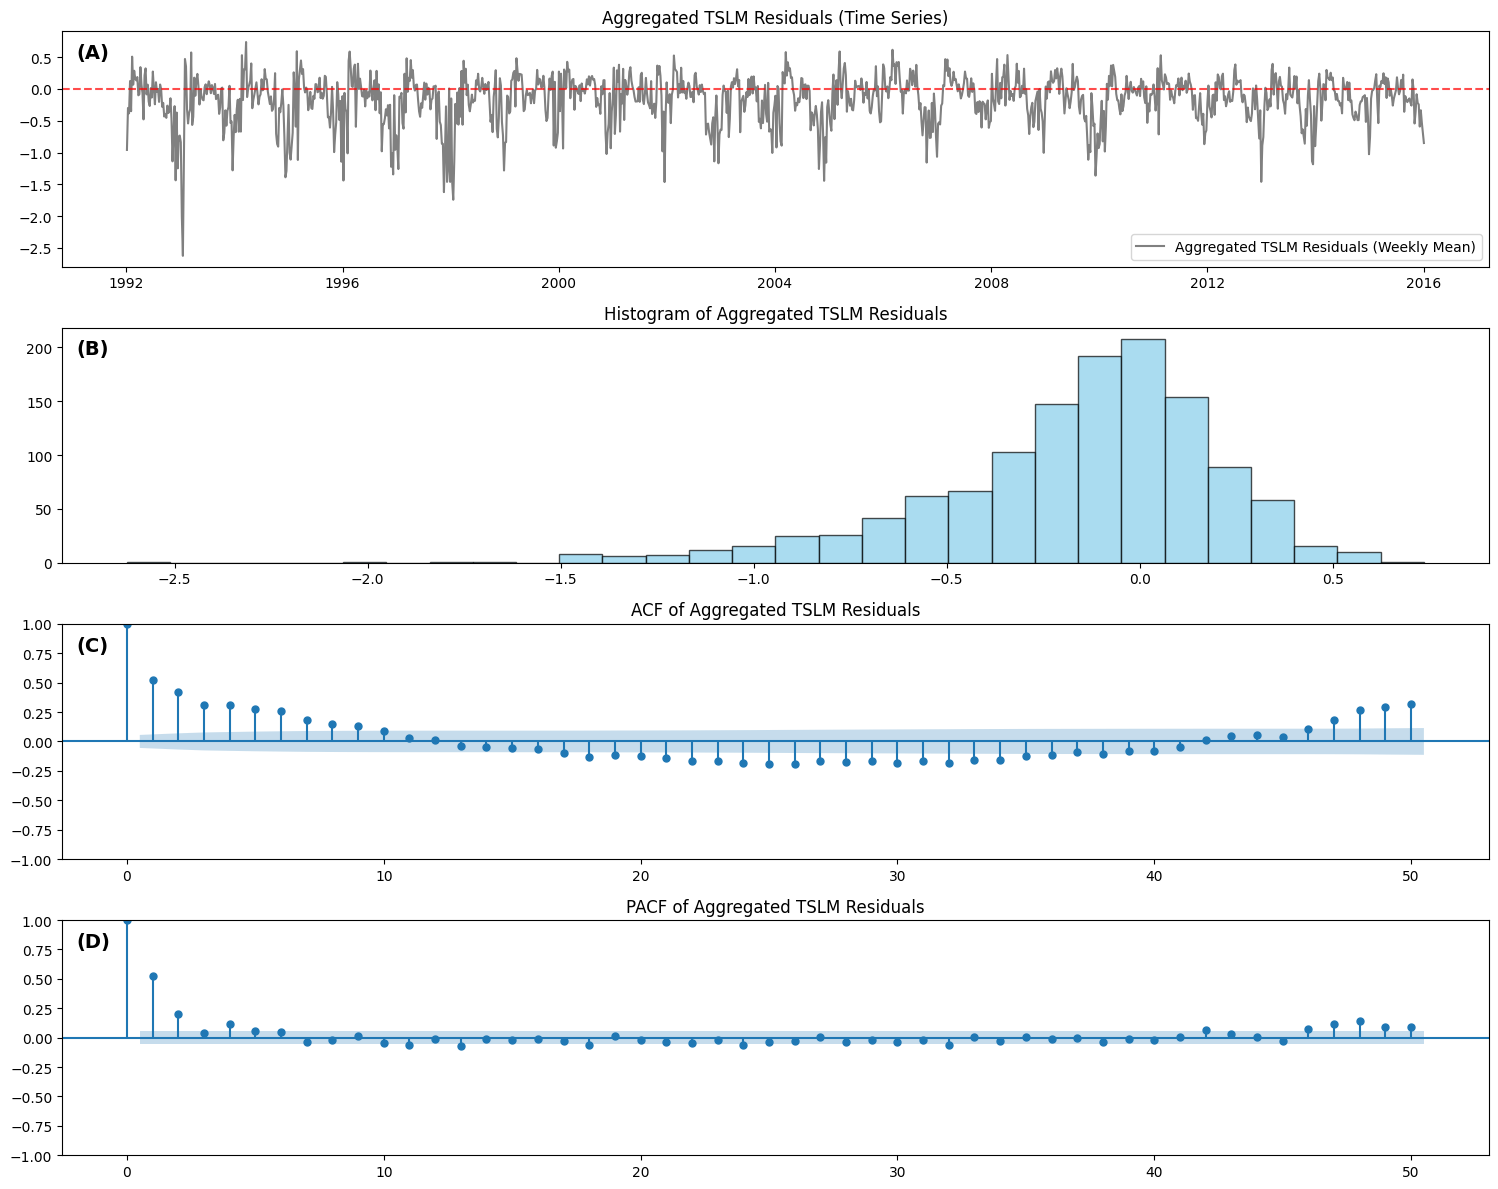

Aggregated TSLM residual analysis plot saved at: ./Abbildungen\aggregated_tslm_residual_analysis.png


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os

# Load the residuals data
residuals_file_path = 'Data_Waldbrand_Zeitreihen/daily_data_merged/TSLM_model_residuals.csv'
residuals_df = pd.read_csv(residuals_file_path, index_col=0, parse_dates=True)

# Ensure proper data alignment
if 'Residuals' not in residuals_df.columns:
    raise ValueError("The file does not contain a 'Residuals' column.")

residuals = residuals_df['Residuals']

# Check for NaN values in the residuals
if residuals.isna().any():
    print("Warning: NaN values found in residuals. These will be dropped for analysis.")
    residuals = residuals.dropna()

# Aggregate residuals to reduce the number of points (e.g., weekly mean)
aggregated_residuals = residuals.resample('W').mean()

# Residual Analysis for Aggregated Data
plt.figure(figsize=(15, 12))

# Residual time series
plt.subplot(411)
plt.plot(aggregated_residuals, label='Aggregated TSLM Residuals (Weekly Mean)', color='gray')
plt.axhline(0, linestyle='--', color='red', alpha=0.7)
plt.text(0.01, 0.95, '(A)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
plt.title('Aggregated TSLM Residuals (Time Series)')
plt.legend()

# Histogram of residuals
plt.subplot(412)
plt.hist(aggregated_residuals.dropna().values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.text(0.01, 0.95, '(B)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
plt.title('Histogram of Aggregated TSLM Residuals')

# ACF plot of residuals
plt.subplot(413)
plot_acf(aggregated_residuals.dropna(), lags=50, ax=plt.gca(), title='ACF of Aggregated TSLM Residuals', alpha=0.05)
plt.text(0.01, 0.95, '(C)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# PACF plot of residuals
plt.subplot(414)
plot_pacf(aggregated_residuals.dropna(), lags=50, ax=plt.gca(), title='PACF of Aggregated TSLM Residuals', alpha=0.05)
plt.text(0.01, 0.95, '(D)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Save the plot to the 'Abbildungen' folder
output_dir = './Abbildungen'
os.makedirs(output_dir, exist_ok=True)
daily_residuals_output_path = os.path.join(output_dir, 'aggregated_tslm_residual_analysis.png')
plt.tight_layout()
plt.savefig(daily_residuals_output_path, dpi=300)
plt.show()

print(f"Aggregated TSLM residual analysis plot saved at: {daily_residuals_output_path}")

## Stationaritätsstatistische Tests


In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import kpss, adfuller

# Suppress warnings in the output
import warnings
warnings.filterwarnings("ignore")

# Load the residuals data from the previously created CSV file
daily_residuals_output_csv_path = "./Data_Waldbrand_Zeitreihen/daily_data_merged/TSLM_model_residuals.csv"

# Ensure the file exists and handle errors
try:
    arima_residuals = pd.read_csv(daily_residuals_output_csv_path, parse_dates=True)
    if 'Residuals' not in arima_residuals.columns:
        raise ValueError("The file does not contain a 'Residuals' column.")
except FileNotFoundError:
    raise FileNotFoundError(f"The file {daily_residuals_output_csv_path} does not exist.")
except ValueError as e:
    raise ValueError(e)

# Extract the residuals
residuals = arima_residuals['Residuals']

# Perform the Augmented Dickey-Fuller test on the residuals
adf_test = adfuller(residuals.dropna())

# Output the results for ADF test
print('ADF Statistic (Residuals): %f' % adf_test[0])
print('p-value (Residuals): %f' % adf_test[1])
print('Critical Values (Residuals):')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

# Determine stationarity based on ADF test
if adf_test[1] < 0.05:
    print("The residuals are stationary according to the ADF test.")
else:
    print("The residuals are not stationary according to the ADF test.")

# Perform the KPSS test on the residuals
kpss_test = kpss(residuals.dropna(), regression='c')  # 'c' for constant in the regression

# Output the results for KPSS test
print('KPSS Statistic (Residuals): %f' % kpss_test[0])
print('p-value (Residuals): %f' % kpss_test[1])
print('Critical Values (Residuals):')
for key, value in kpss_test[3].items():
    print('\t%s: %.3f' % (key, value))

# Determine stationarity based on KPSS test
if kpss_test[1] < 0.05:
    print("The residuals are not stationary according to the KPSS test.")
else:
    print("The residuals are stationary according to the KPSS test.")


ADF Statistic (Residuals): -46.882384
p-value (Residuals): 0.000000
Critical Values (Residuals):
	1%: -3.430
	5%: -2.862
	10%: -2.567
The residuals are stationary according to the ADF test.
KPSS Statistic (Residuals): 1.812774
p-value (Residuals): 0.010000
Critical Values (Residuals):
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
The residuals are not stationary according to the KPSS test.


## Cross validation

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Path to the saved TSLM model
model_path = 'Data_Waldbrand_Zeitreihen/Model_Results/TSLM_model.pkl'

# Load the model
model = joblib.load(model_path)

# Load the daily data
daily_file_path = './Data_Waldbrand_Zeitreihen/daily_fire_counts.csv'
daily_data = pd.read_csv(daily_file_path)

# Rename columns for clarity and parse dates
daily_data.rename(columns={"DISCOVERY_DATE": "Date", "Daily Fire Counts": "Fire_Count"}, inplace=True)
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
daily_data.set_index('Date', inplace=True)

# Apply log transformation to the daily fire counts (as was done during training)
daily_data['Log_Fire_Count'] = np.log1p(daily_data['Fire_Count'])

# Create additional features (as in the model)
daily_data['Time_Trend'] = np.arange(len(daily_data))
daily_data['Lag_1'] = daily_data['Log_Fire_Count'].shift(1)
daily_data['Lag_2'] = daily_data['Log_Fire_Count'].shift(2)

# Additional predictors
daily_data['Precipitation'] = np.random.rand(len(daily_data))  # Replace with actual data
daily_data['Inferred_Wind_Speed'] = np.random.rand(len(daily_data))  # Replace with actual data
daily_data['MaxTemperature'] = np.random.rand(len(daily_data))  # Replace with actual data
daily_data['MinTemperature'] = np.random.rand(len(daily_data))  # Replace with actual data

# Drop rows with missing values due to lagging
daily_data.dropna(inplace=True)

# Prepare for cross-validation
X = daily_data[['Time_Trend', 'Lag_1', 'Lag_2', 'Precipitation', 'Inferred_Wind_Speed', 'MaxTemperature', 'MinTemperature']]
y = daily_data['Log_Fire_Count']
n_splits = 5
fold_size = int(len(X) / n_splits)

mse_scores, mae_scores, rmse_scores = [], [], []
for i in range(n_splits - 1):
    train_end = (i + 1) * fold_size
    test_end = (i + 2) * fold_size

    X_train, X_test = X[:train_end], X[train_end:test_end]
    y_train, y_test = y[:train_end], y[train_end:test_end]

    # Add a constant for the intercept
    X_test = sm.add_constant(X_test, has_constant='add')

    # Ensure that the columns in X_test match the model's exogenous variables
    X_test = X_test[model.model.exog_names]

    # Predict using the model
    predictions = model.predict(X_test)

    # Calculate different error metrics
    mse = mean_squared_error(y_test[:len(predictions)], predictions)
    mae = mean_absolute_error(y_test[:len(predictions)], predictions)
    rmse = np.sqrt(mse)

    # Store the scores for final averaging
    mse_scores.append(round(mse, 4))
    mae_scores.append(round(mae, 4))
    rmse_scores.append(round(rmse, 4))

    # Print fold-specific scores
    print(f"Fold {i + 1} MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Average scores across all folds
average_scores = {
    'Metric': ['MSE', 'MAE', 'RMSE'],
    'Average Value': [
        round(np.mean(mse_scores), 4),
        round(np.mean(mae_scores), 4),
        round(np.mean(rmse_scores), 4)
    ]
}

# Create a DataFrame for the averaged values
averaged_scores_df = pd.DataFrame(average_scores)

# Define the path to save the table as an image
output_dir = "./Abbildungen"
os.makedirs(output_dir, exist_ok=True)
output_image_path = os.path.join(output_dir, "TSLM_averaged_scores_table.png")

# Save the table as a LaTeX-like styled image
fig, ax = plt.subplots(figsize=(5, 1.5))  # Reduced figure size to minimize margins
ax.axis('tight')
ax.axis('off')

# Create a better-presented table with LaTeX styling
cell_text = [[f"{val}" for val in row] for row in averaged_scores_df.values]
col_labels = averaged_scores_df.columns
ax.table(cellText=cell_text, colLabels=col_labels, loc='center', cellLoc='center', edges='horizontal')

plt.savefig(output_image_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

print(f"Averaged scores table saved as an image at: {output_image_path}")

# Print average scores
print("Average MSE:", round(np.mean(mse_scores), 4))
print("Average MAE:", round(np.mean(mae_scores), 4))
print("Average RMSE:", round(np.mean(rmse_scores), 4))

Fold 1 MSE: 0.2358, MAE: 0.3835, RMSE: 0.4856
Fold 2 MSE: 0.1919, MAE: 0.3443, RMSE: 0.4380
Fold 3 MSE: 0.1577, MAE: 0.3207, RMSE: 0.3971
Fold 4 MSE: 0.1586, MAE: 0.3167, RMSE: 0.3983
Averaged scores table saved as an image at: ./Abbildungen\TSLM_averaged_scores_table.png
Average MSE: 0.186
Average MAE: 0.3413
Average RMSE: 0.4298
